We're calculating Tajima's pi (average pairwise genetic distance) per OTU and then calculating summary stats from these pi values. These include Hill numbers 1-5 accounting for OTU sampling differences in two different ways*, average, median, standard deviation, and variance.  

Accounted for sampling differences: 
* randomly sample 10 OTUs with replacement, calculate Hill number, and repeat 100 times
* divide Hill number by the number of unique OTUs per cell ("OTU richness")

I'm interested in seeing how these two methods for controlling for sampling bias impact the Hill number calculations.


*Note: normally I include many more exploratory plots with better annotation, but the remote Mac I'm working on has a weird font problem. Since we don't have physical access to the computers and I don't want to break the machine on accident, I'm just going to make exploratory plots separately on my laptop*

In [132]:
suppressMessages(library(ape))
suppressMessages(library(here))
suppressMessages(library(tictoc))
suppressMessages(library(raster))
suppressMessages(library(data.table))
suppressMessages(library(tidyverse))
suppressMessages(library(furrr))
suppressMessages(library(sf))
suppressMessages(library(skimr))

## Functions

Function to calculate Hill numbers.

In [2]:
## Get one hill number from a list of genetic distances. Original python code written by Isaac Overcast, with slight modifications (correct = TRUE implemented by CMF)
## dists are the OTU Tajima's pi
## order is the q order of the Hill number
## correct indicates if you want to correct for species richness or not. Default is TRUE
hill_calc <- function(dists, order = 1, correct = TRUE) { 
  if (order == 0) {
    return(length(dists))
  }
  if (order == 1) {
    h1 = exp(entropy::entropy(dists))
    if (correct) {
        return(h1 / length(dists))
    } else return(h1)
    
  }
  else {
    tot = sum(dists)
    proportions = dists/tot
    prop_order = proportions**order
    h2 = sum(prop_order)**(1/(1-order))
    if (correct) {
        return(h2 / length(dists))
    } else return(h2)
  }
}

Function to calculate pairwise sequence divergence. All sequences have > 50% sequence overlap, so I don't need to account for it here. I'm extracting the relevant sequences from the sequence data frame (sdf) and using dist.dna to calculate average pairwise genetic distances with pairwise deletion.

In [101]:
# ids is a vector of sequence IDs to be analyzed
# sdf is the sequence data frame created after reading in the FASTA sequences
pairwise_div <- function(ids){
    seq_df <- sdf[recordID %in% ids
       ][, seq := str_split(seq, "")]
    
    pi <- as.DNAbin(seq_df$seq) %>% 
        dist.dna(model = "raw", pairwise.deletion = TRUE) %>% 
        mean()
    
    return(pi)
}

## Filter metadata

Read in and take a look at metadata

In [554]:
tic()
bold_meta <- fread(here("output", "spreadsheets", "final_filter_meta.csv"))
toc()

bold_meta %>% glimpse()

3.82 sec elapsed
Observations: 3,048,396
Variables: 33
$ recordID             <int> 797197, 1674336, 1416487, 609365, 797199, 147331…
$ bin_uri              <chr> "BOLD:AAA0006", "BOLD:AAA0006", "BOLD:AAA0006", …
$ order_taxID          <int> 113, 113, 113, 113, 113, 113, 113, 113, 113, 113…
$ order_name           <chr> "Lepidoptera", "Lepidoptera", "Lepidoptera", "Le…
$ family_taxID         <int> 546510, 546510, NA, 546510, 546510, NA, NA, NA, …
$ family_name          <chr> "Depressariidae", "Depressariidae", "", "Depress…
$ subfamily_taxID      <int> 2479, 2479, NA, 2479, 2479, NA, NA, NA, 2479, 24…
$ subfamily_name       <chr> "Stenomatinae", "Stenomatinae", "", "Stenomatina…
$ genus_taxID          <int> 66559, 66559, NA, 66559, 66559, NA, NA, NA, 6655…
$ genus_name           <chr> "Stenoma", "Stenoma", "", "Stenoma", "Stenoma", …
$ species_taxID        <int> 111154, 111154, NA, 111154, 111154, NA, NA, NA, …
$ species_name         <chr> "Stenoma Janzen44", "Stenoma Janzen44", "", "St

Convert to **sf** object for geographic filtering. I'm also removing a lot of the unnecessary columns to make filtering go faster. If I ever need them, I can just rejoin with the original data frame by the recordID.

In [555]:
# convert to sf object and project to behrmann equal area crs
behrmann_crs <- "+proj=cea +lon_0=0 +lat_ts=30 +x_0=0 +y_0=0 +datum=WGS84 +ellps=WGS84 +units=m +no_defs"

# unnecessary columns
col_remove <- c("order_taxID",
                "family_taxID",
                "subfamily_taxID",
                "subfamily_name",
                "genus_taxID",
                "genus_name",
                "species_taxID",
                "species_name",
                "collectiondate_start",
                "collectiondate_end",
                "habitat",
                "coord_accuracy",
                "elev",
                "elev_accuracy",
                "depth",
                "country",
                "province_state",
                "region",
                "sequenceID",
                "markercode",
                "genbank_accession",
                "seq_primers",
                "marker_codes",
                "n_nucs_all_trim",
                "num_continents",
                "numseqs",
                "full_name")

# slim down data table and convert geometry column back to lon and lat
bold_meta[,(col_remove) := NULL
         ][,lon := str_split_fixed(geometry, "\\|", 2)[,1] %>% as.numeric()
          ][,lat := str_split_fixed(geometry, "\\|", 2)[,2] %>% as.numeric()
           ][,geometry := NULL]

tic()
bold_sf <- st_as_sf(bold_meta, coords = c("lon", "lat"), 
                         crs = 4326, agr = "constant") %>% 
  st_transform(crs = behrmann_crs)
toc()

62.287 sec elapsed


Get cell numbers for each geographic resolution

In [561]:
template_high <- raster(here("data", "templates", "template_high.tif"))
template_medium <- raster(here("data", "templates", "template_medium.tif"))
template_low <- raster(here("data", "templates", "template_low.tif"))

bold_coords <- st_coordinates(bold_sf)


bold_sf_pts <- bold_sf %>% 
    mutate(cell_high = cellFromXY(template_high, bold_coords),
          cell_medium = cellFromXY(template_medium, bold_coords),
          cell_low = cellFromXY(template_low, bold_coords))

1.022 sec elapsed


Writing the transformed data frame to csv so I can read in the smaller data set and make figures on my laptop.

In [616]:
st_write(bold_sf_pts, here("output", "spreadsheets", "bold_sf_pts.csv"))

Writing layer `bold_sf_pts' to data source `/Users/labuser/Desktop/connorfrench/bigass-phylogeography/BigAss-phylogeography/output/spreadsheets/bold_sf_pts.csv' using driver `CSV'
Writing 3048396 features with 8 fields and geometry type Point.


In [5]:
# since I'm going back and forth between remote computer and local, I'm putting this here to read in the bold_sf_pts data frame if it's not already loaded
tic()
if (!exists("bold_sf_pts")) {
    bold_sf_pts <- fread(here("output", "spreadsheets", "bold_sf_pts.csv"))
} else setDT(bold_sf_pts)
toc()

1.258 sec elapsed


In [10]:
# function to filter bold data by the resolution, number of individuals per OTU, and number of OTUs per cell, and calculate summaries of the data
# dt = data table to filter, resolution = string ("high", "medium", "low"), min_ind = integer, min_otu = integer
filter_occs <- function(resolution, min_ind, min_otu, calc_pi = FALSE) {
    
    cell_filter <- paste0("cell_", resolution)
    
    dt_filter <- bold_sf_pts[,ind_count := .N, by = c(cell_filter, "bin_uri")
           ][ind_count >= min_ind
            ]
    
    
    dt_filter <- dt_filter[,.(total_ind = uniqueN(recordID),
                             n_ind_min = min(ind_count),
                             n_ind_median = median(ind_count) %>% as.double(),
                             n_ind_max = max(ind_count),
                             n_ind_var = var(ind_count),
                             n_otu = uniqueN(bin_uri),
                             n_order = uniqueN(order_name)),
                             by = c(cell_filter)
                          ][n_otu >= min_otu]
    
    # rename cell column to allow for row-binding data.tables later
    setnames(dt_filter, cell_filter, "cell")
    
    # add ID columns
    dt_filter <- dt_filter[,res_filter := resolution
                          ][,ind_filter := min_ind
                           ][,otu_filter := min_otu]
    
    return(dt_filter)
}

It took dplyr > 200 seconds to filter for a single filtering regime! data.table is awesome.

In [11]:
# since the filtering process is fast, I'm including some liberal and conservative filtering parameters.
res_list <- c("high", "medium", "low")
ind_list <- c(3, 5, 10, 15)
otu_list <- c(5, 10, 15, 20)

# get all combinations of filtering parameters
input_list <- expand_grid(res_list, ind_list, otu_list)

tic()
bold_filtered <- purrr::pmap(list(input_list$res_list, 
                             input_list$ind_list,
                             input_list$otu_list),
                             filter_occs)  %>% 
    rbindlist()
toc()

glimpse(bold_filtered)

56.679 sec elapsed
Observations: 22,288
Variables: 11
$ cell         <int> 22055, 25328, 22781, 27464, 33230, 22417, 17731, 15580, …
$ total_ind    <int> 274225, 7514, 5839, 786, 676, 3726, 1067, 349, 727, 3426…
$ n_ind_min    <int> 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,…
$ n_ind_median <dbl> 47, 7, 8, 7, 9, 6, 10, 5, 9, 9, 6, 11, 5, 6, 5, 30, 16, …
$ n_ind_max    <int> 1964, 287, 61, 47, 104, 68, 86, 49, 69, 52, 19, 64, 24, …
$ n_ind_var    <dbl> 4.703042e+04, 2.966762e+03, 8.135492e+01, 1.527908e+02, …
$ n_otu        <int> 13113, 1177, 877, 132, 86, 701, 133, 71, 108, 491, 113, …
$ n_order      <int> 19, 10, 6, 4, 1, 10, 2, 8, 5, 13, 9, 2, 9, 10, 3, 10, 14…
$ res_filter   <chr> "high", "high", "high", "high", "high", "high", "high", …
$ ind_filter   <dbl> 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,…
$ otu_filter   <dbl> 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,…


In [12]:
# interested in:
# the total number of individuals (total_ind) and otus (total_otu),
# the number of cells
# the variance in the median number of individuals per otu per cell (ind_var), 
# the median of the median number of individuals per otu per cell (ind_median), **this tells us the average across cells for each filtering regime
# and the variance in the number of otus per cell (otu_var) for each filtering regime

bold_summary <- bold_filtered[,.(total_ind = sum(total_ind),
                                 total_otu = sum(n_otu),
                                 num_cells = .N,
                                 ind_var = var(n_ind_median),
                                 ind_median = median(n_ind_median),
                                 otu_var = var(n_otu)),
                             by = .(res_filter, ind_filter, otu_filter)]

glimpse(bold_summary)

Observations: 48
Variables: 9
$ res_filter <chr> "high", "high", "high", "high", "high", "high", "high", "h…
$ ind_filter <dbl> 3, 3, 3, 3, 5, 5, 5, 5, 10, 10, 10, 10, 15, 15, 15, 15, 3,…
$ otu_filter <dbl> 5, 10, 15, 20, 5, 10, 15, 20, 5, 10, 15, 20, 5, 10, 15, 20…
$ total_ind  <int> 2478732, 2457237, 2437800, 2421448, 2178028, 2155807, 2139…
$ total_otu  <int> 188555, 184309, 180622, 177684, 101509, 98997, 97192, 9587…
$ num_cells  <int> 1913, 1263, 948, 774, 1031, 645, 491, 412, 422, 279, 217, …
$ ind_var    <dbl> 21086.125, 31812.392, 42188.904, 51146.297, 38932.567, 617…
$ ind_median <dbl> 5.00, 5.00, 5.25, 6.00, 9.00, 10.00, 10.00, 11.00, 21.00, …
$ otu_var    <dbl> 176643.30, 261015.77, 339852.59, 408038.92, 150578.35, 232…


I'm placing a hard filter on any data set that results in less than 500 cells, because it's difficult to conduct machine learning inference with a lower sample size than that. In addition, I'm removing cells with a minimum number of OTUs equal to 5 because it's too liberal of a filter anyways

In [13]:
bold_summary_cellfilt <- bold_summary[num_cells >= 500 & otu_filter >= 10]
bold_summary_cellfilt

res_filter,ind_filter,otu_filter,total_ind,total_otu,num_cells,ind_var,ind_median,otu_var
<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
high,3,10,2457237,184309,1263,31812.39,5.00,261015.8
high,3,15,2437800,180622,948,42188.90,5.25,339852.6
high,3,20,2421448,177684,774,51146.30,6.00,408038.9
high,5,10,2155807,98997,645,61714.36,10.00,232730.5
medium,3,10,2551529,190855,957,10438.09,5.00,415688.8
medium,3,15,2541095,188888,788,12535.72,6.00,495756.1
medium,3,20,2528616,186502,646,15230.80,6.00,591555.9
medium,5,10,2248218,103919,538,18384.70,10.00,326354.9
low,3,10,2647868,192079,576,16307.92,6.00,931162.4


The total number of individuals does not greatly differ among filtering regimes, so I'm not going to consider it for further filtering.

The goal is to have the lowest variance in median number of individuals per OTU and lowest variance in number of OTUs per cell while maintaining a reasonable number of cells for modeling.

The color scale for num_cells is diverging so I can see which data sets diverge most from the average number of cells (mostly interested in those at the lower end).

Overall patterns:  
* The high resolution has the highest variance in the number of individuals per OTU per cell
* The more liberal the filter, the higher number of cells retained (duh)
* The medium resolution seems to strike a balance between variance in the number of individuals per OTU per cell, median number of individuals per OTU per cell, and number of cells.
* The median number of individuals per OTU per cell is never lower than 5

Not plotted:
There is a 46% decrease in the total number of OTUs when increasing the minimum number of individuals per OTU per cell from 3 to 5 for the high and medium resolution filters, when keeping the minimum OTU filter constant.

**Conclusion**: I'm going to consider the high and medium resolution filtering regimes going forward. The low resolution filtering regimes have especially low numbers of cells (close to 500), so I'm going to axe those from consideration. The other filtering schemes will likely be sufficient for modeling.

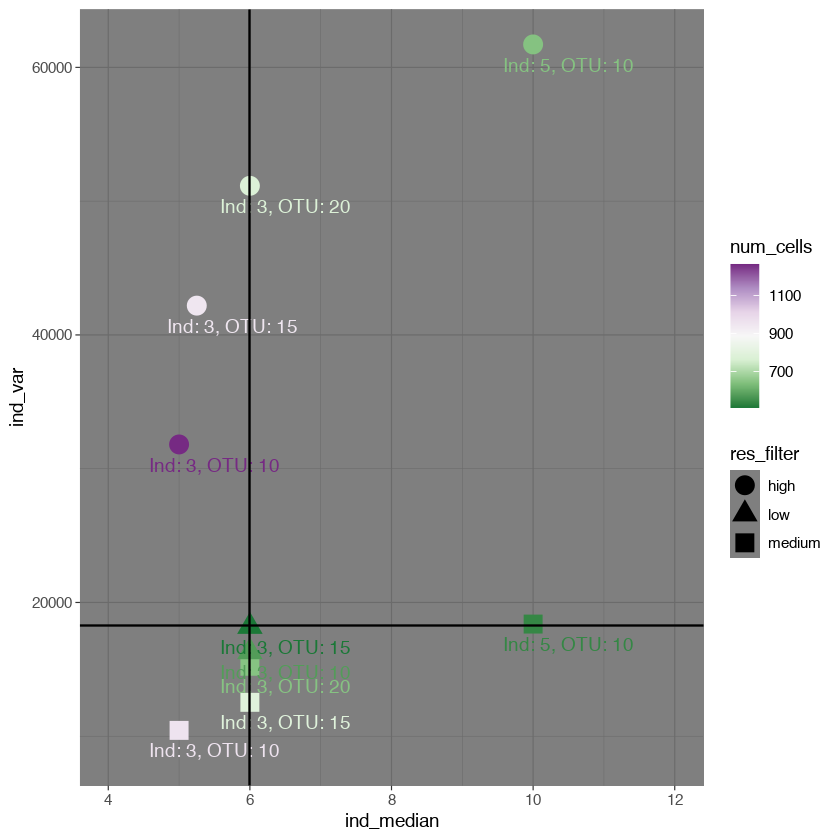

In [247]:
bold_summary_cellfilt %>% 
mutate(ind_filter = as.factor(ind_filter),
       otu_filter = as.factor(otu_filter))  %>% 
ggplot(aes(x = ind_median, 
           y = ind_var, 
           color = num_cells, 
           shape = res_filter)) + 
    geom_point(size = 5) +
    geom_text(aes(label = paste0("Ind: ", ind_filter, ", ", "OTU: ", otu_filter)), nudge_x = 0.5, nudge_y = -1500) +
    geom_vline(xintercept = median(bold_summary_cellfilt$ind_median)) +
    geom_hline(yintercept = median(bold_summary_cellfilt$ind_var)) +
    scale_color_distiller(palette = "PRGn") +
    xlim(4, 12) +
    theme_dark()

## Calculate pairwise nucleotide differences

In [14]:
# read in fasta alignment file names
fasta_list <- fread(here("output", "spreadsheets", "fasta_filenames.csv"))
fasta_list$full_path <- here("output", "alignments", fasta_list$filename)

In [15]:
# read in fasta files and keep as two column data frame
tic()
s <- map(fasta_list$full_path, ~seqinr::read.fasta(.x, as.string = TRUE)) %>% 
unlist()
toc()

sdf <- s %>% enframe(name = "recordID", value = "seq")
setDT(sdf)


276.831 sec elapsed


In [21]:
bold_final_filter <- bold_filtered[ind_filter %in% bold_summary_cellfilt$ind_filter & 
             otu_filter %in% bold_summary_cellfilt$otu_filter &
             res_filter %in% bold_summary_cellfilt$res_filter]

glimpse(bold_final_filter)

Observations: 10,893
Variables: 11
$ cell         <int> 22055, 25328, 22781, 27464, 33230, 22417, 17731, 15580, …
$ total_ind    <int> 274225, 7514, 5839, 786, 676, 3726, 1067, 349, 727, 3426…
$ n_ind_min    <int> 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,…
$ n_ind_median <dbl> 47, 7, 8, 7, 9, 6, 10, 5, 9, 9, 6, 11, 5, 6, 5, 30, 16, …
$ n_ind_max    <int> 1964, 287, 61, 47, 104, 68, 86, 49, 69, 52, 19, 64, 24, …
$ n_ind_var    <dbl> 4.703042e+04, 2.966762e+03, 8.135492e+01, 1.527908e+02, …
$ n_otu        <int> 13113, 1177, 877, 132, 86, 701, 133, 71, 108, 491, 113, …
$ n_order      <int> 19, 10, 6, 4, 1, 10, 2, 8, 5, 13, 9, 2, 9, 10, 3, 10, 14…
$ res_filter   <chr> "high", "high", "high", "high", "high", "high", "high", …
$ ind_filter   <dbl> 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,…
$ otu_filter   <dbl> 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, …


In [118]:
calc_all_pairwise_div <- function(res_filter, ind_filter, otu_filter) {
    cell_res <- paste0("cell_", res_filter)
    df_out <- bold_sf_pts[,ind_count := .N, by = c(cell_res, "bin_uri")
           ][ind_count >= ind_filter
            ]
    
    df_out <- df_out[,otu_num := uniqueN(bin_uri), by = cell_res
                 ][otu_num >= otu_filter
                  ]
    
    df_out <- df_out[,pi := pairwise_div(recordID), by = c(cell_res, "bin_uri")]
    
    df_out <- df_out[,.(num_ind = unique(ind_count),
                       order = unique(order_name),
                       pi = unique(pi)), 
                       by = c(cell_res, "bin_uri")]
    
    setnames(df_out, cell_res, "cell")
    
    return(df_out)
}

In [ ]:
tic()
df_test <- calc_all_pairwise_div(res_filter = "medium", ind_filter = 3, otu_filter = 10)
toc()

In [119]:
med_3_10 <- df_test[,.(num_ind = unique(ind_count),
                       order = unique(order_name),
                       pi = unique(pi)), 
                       by = .(cell_medium, bin_uri)] 

setnames(med_3_10, "cell_medium", "cell")

cell,bin_uri,num_ind,order,pi
<int>,<chr>,<int>,<chr>,<dbl>
5448,BOLD:AAA0006,21,Lepidoptera,0.0058795703
5448,BOLD:AAA0007,48,Lepidoptera,0.0032591444
5448,BOLD:AAA0008,50,Lepidoptera,0.0001830117
5448,BOLD:AAA0009,6,Lepidoptera,0.0040526849
5448,BOLD:AAA0010,32,Lepidoptera,0.0006961860
5448,BOLD:AAA0011,105,Lepidoptera,0.0024404010


In [115]:
fwrite(med_3_10, here("output", "spreadsheets", "med_3_10_pi.csv"))

Now to calculate the summary statistics per cell. Hill numbers are corrected by OTU richness per cell.

In [127]:
calc_sumstats <- function(df) {
   df_out <- df[,.(avg_pi = mean(pi),
          median_pi = median(pi),
          sqrt_pi = sqrt(mean(pi)),
          sd_pi = sd(pi),
          var_pi= var(pi),
          num_otu = uniqueN(bin_uri),
          hill_1 = hill_calc(pi, 1),
          hill_2 = hill_calc(pi, 2),
          hill_3 = hill_calc(pi, 3),
          hill_4 = hill_calc(pi, 4),
          hill_5 = hill_calc(pi, 5)),
          by = "cell"]
  return(df_out)
}

In [128]:
tic()
sumstats <- calc_sumstats(med_3_10)
toc()

head(sumstats)

0.31 sec elapsed


cell,avg_pi,median_pi,sqrt_pi,sd_pi,var_pi,num_otu,hill_1,hill_2,hill_3,hill_4,hill_5
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5448,0.002084775,0.001234568,0.04565934,0.002550134,6.503185e-06,13300,0.5398728,0.4006171,0.3200303,0.2698272,0.2362016
6364,0.002351639,0.001361903,0.04849370,0.002994169,8.965047e-06,1192,0.5119873,0.3817164,0.3080146,0.2641870,0.2362316
5631,0.002258771,0.001374665,0.04752653,0.002636205,6.949575e-06,877,0.5505554,0.4236279,0.3494859,0.3032256,0.2724399
6892,0.002583159,0.001400230,0.05082479,0.003207600,1.028869e-05,270,0.5140907,0.3942914,0.3266356,0.2851218,0.2579253
8335,0.002076913,0.001054852,0.04557316,0.002734620,7.478144e-06,189,0.4974995,0.3670452,0.2928867,0.2492382,0.2216627
5629,0.002599724,0.001586310,0.05098749,0.003029968,9.180709e-06,1862,0.5523312,0.4241509,0.3505987,0.3039582,0.2719015


In [129]:
skimr::skim(sumstats)

── Data Summary ────────────────────────
                           Values  
Name                       sumstats
Number of rows             957     
Number of columns          12      
_______________________            
Column type frequency:             
  numeric                  12      
________________________           
Group variables            None    

── Variable type: numeric ──────────────────────────────────────────────────────
   skim_variable n_missing complete_rate         mean            sd           p0
 1 cell                  0             1 4583.        3305.         48          
 2 avg_pi                0             1    0.00286      0.00117     0.000432   
 3 median_pi             0             1    0.00172      0.00114     0          
 4 sqrt_pi               0             1    0.0526       0.00975     0.0208     
 5 sd_pi                 0             1    0.00337      0.00107     0.000775   
 6 var_pi                0             1    0.0000125    0.00000829

In [133]:
fwrite(sumstats, here("output", "spreadsheets", "med_3_10_sumstats.csv"))

In [239]:
paste0("Richness")
summary(fasta_sumstats$richness)

paste0("Hill 1")
summary(fasta_sumstats$hill_1)

paste0("Hill 1 corrected")
summary(fasta_sumstats$hill_1_c)

paste0("Hill 1 resample")
summary(fasta_sumstats$hill_1_r)

paste0("Average pi")
summary(fasta_sumstats$avg_pi)

paste0("Median pi")
summary(fasta_sumstats$median_pi)


[1] "Richness"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   10.0    16.0    40.0   226.1   151.0  9936.0 

[1] "Hill 1"

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   2.881    9.669   23.422  130.826   83.897 5780.860 

[1] "Hill 1 corrected"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2029  0.5337  0.5891  0.5914  0.6495  0.9723 

[1] "Hill 1 resample"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  3.016   5.785   6.251   6.280   6.799   9.747       3 

[1] "Average pi"

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0006159 0.0024941 0.0029882 0.0031632 0.0036133 0.0223606 

[1] "Median pi"

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.001420 0.001855 0.002084 0.002433 0.022516 

It looks like the resampling method returns a few NAs! I don't know what they're from, but the corrected method of calculating Hill numbers conveys much of the same information, so I'm going to go with the corrected values. 

In [240]:
filter(fasta_sumstats, is.na(hill_1_r))

cells,avg_pi,median_pi,sd_pi,var_pi,richness,hill_1,hill_2,hill_3,hill_4,⋯,hill_1_c,hill_2_c,hill_3_c,hill_4_c,hill_5_c,hill_1_r,hill_2_r,hill_3_r,hill_4_r,hill_5_r
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
610,0.001377272,0.0006611153,0.001686415,2.843996e-06,10,5.031984,4.256456,3.932519,5.031984,⋯,0.5031984,0.4256456,0.3932519,0.3767629,0.3668295,NA,4.361142,3.963474,4.025759,3.790077
1241,0.001811893,0.0000000000,0.003040131,9.242396e-06,13,4.275040,3.612409,3.302378,4.275040,⋯,0.3288493,0.2778776,0.2540291,0.2403825,0.2315504,NA,3.007234,2.818323,2.718252,2.895737
3904,0.002221667,0.0000000000,0.005483623,3.007012e-05,18,3.651395,2.665172,2.309921,3.651395,⋯,0.2028553,0.1480651,0.1283290,0.1191281,0.1140707,NA,NaN,NaN,2.004682,NaN


Hill 1 when correcting for species richness conveys much of the same information as the resampling-based method.


Call:
lm(formula = hill_1_c ~ hill_1_r, data = fasta_sumstats)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.113816 -0.010342  0.000622  0.011435  0.051778 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.081103   0.006350  -12.77   <2e-16 ***
hill_1_r     0.107326   0.001002  107.14   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01869 on 470 degrees of freedom
  (3 observations deleted due to missingness)
Multiple R-squared:  0.9607,	Adjusted R-squared:  0.9606 
F-statistic: 1.148e+04 on 1 and 470 DF,  p-value: < 2.2e-16


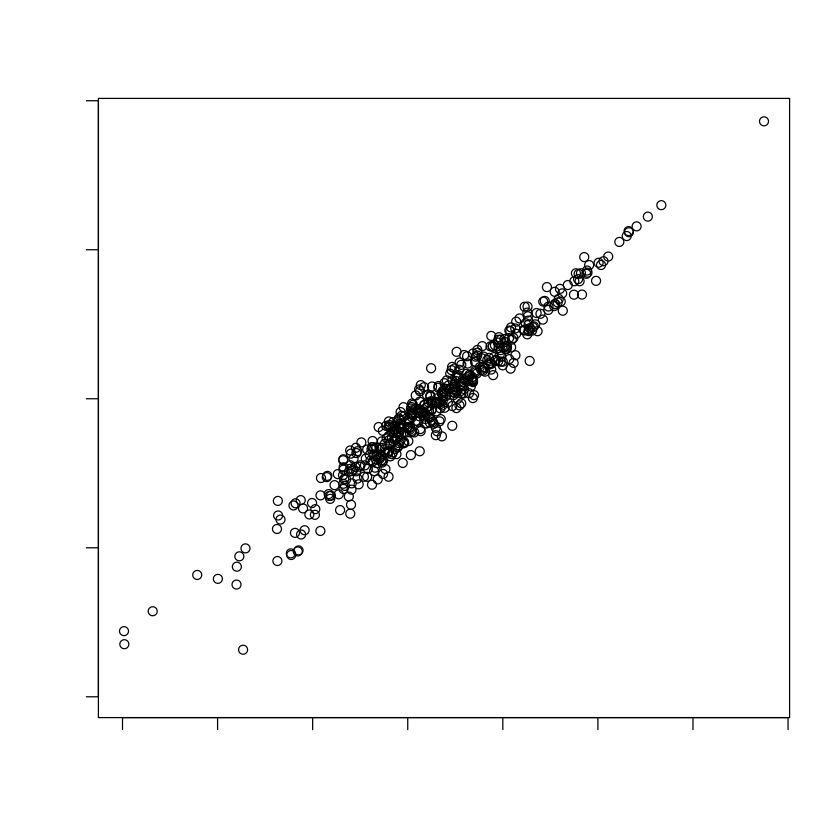

In [241]:
plot(hill_1_c ~ hill_1_r, data = fasta_sumstats)
summary(lm(hill_1_c ~ hill_1_r, data = fasta_sumstats))

Relationship between OTU richness and Hill 1. A strong relationship is expected.

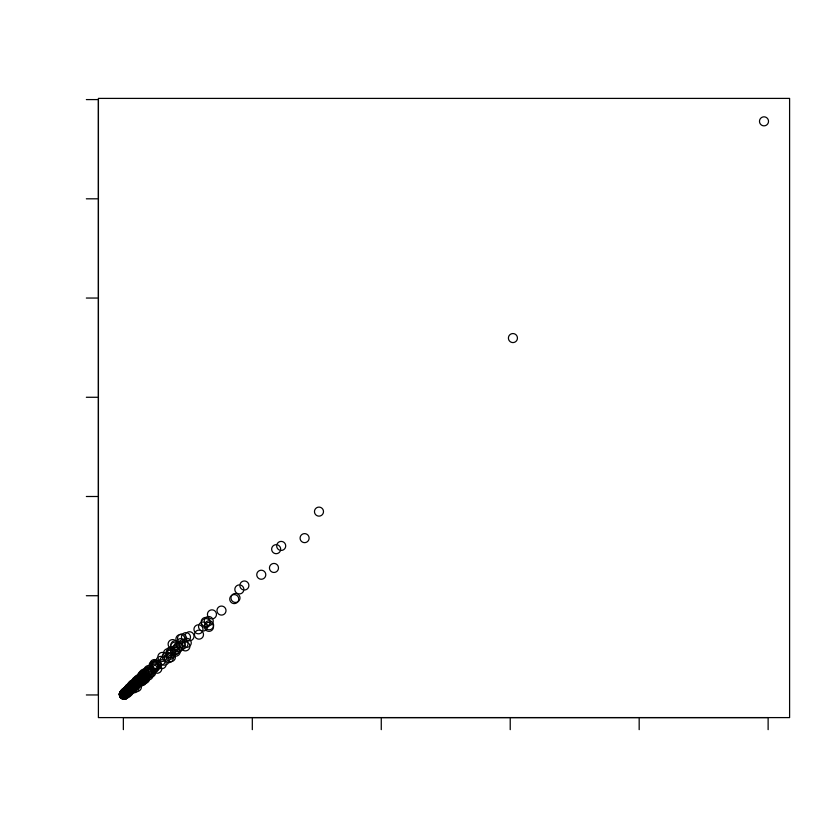

In [242]:
plot(hill_1 ~ richness, data = fasta_sumstats)

Relationship between OTU richness and corrected Hill 1. No relationship is expected.

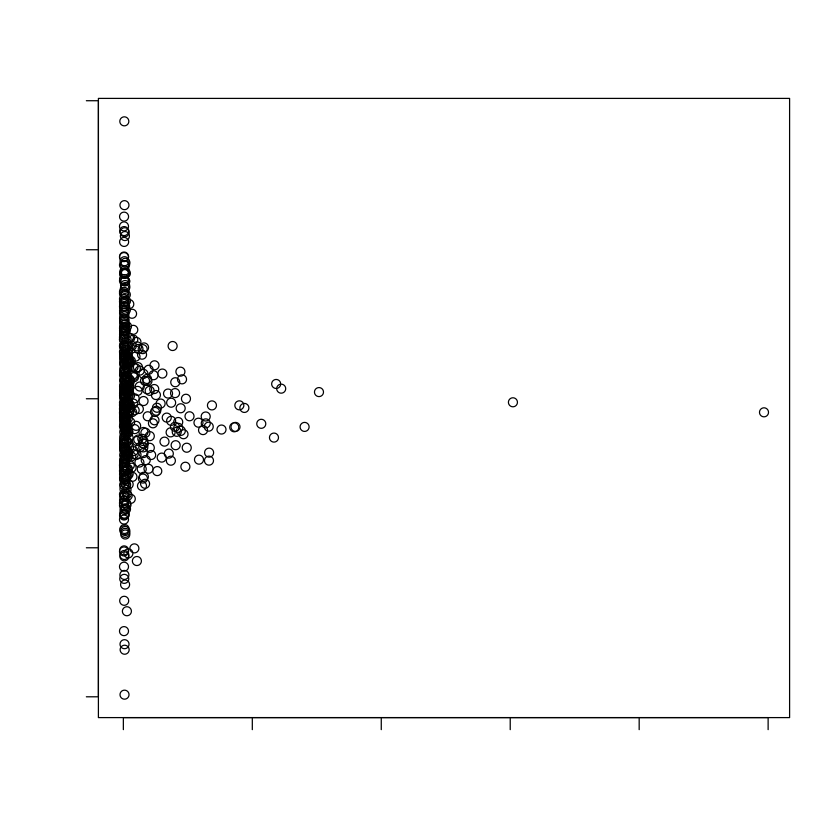

In [243]:
plot(hill_1_c ~ richness, data = fasta_sumstats)

Relationship between average pi and richness. Hard to see with outliers, but I doubt there's a strong relationship. I'll filter out the outliers and see.


Call:
lm(formula = avg_pi ~ richness, data = fasta_sumstats)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0025648 -0.0006649 -0.0001720  0.0004611  0.0191802 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.182e-03  6.421e-05  49.548   <2e-16 ***
richness    -8.113e-08  9.229e-08  -0.879     0.38    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.001324 on 473 degrees of freedom
Multiple R-squared:  0.001631,	Adjusted R-squared:  -0.0004795 
F-statistic: 0.7728 on 1 and 473 DF,  p-value: 0.3798


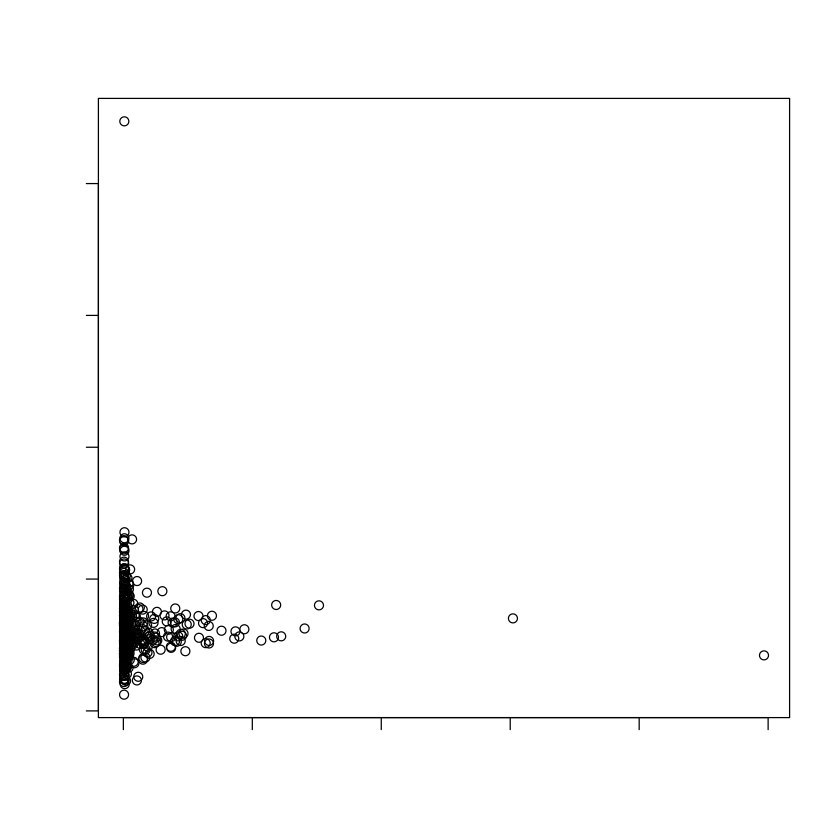

In [244]:
plot(avg_pi ~ richness, data = fasta_sumstats)
summary(lm(avg_pi ~ richness, data = fasta_sumstats))

Still no relationship.


Call:
lm(formula = avg_pi ~ richness, data = fasta_sumstats_filtered)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0025421 -0.0006531 -0.0001364  0.0005422  0.0036203 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.161e-03  5.532e-05   57.14   <2e-16 ***
richness    -2.974e-07  2.342e-07   -1.27    0.205    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.001005 on 449 degrees of freedom
Multiple R-squared:  0.003579,	Adjusted R-squared:  0.00136 
F-statistic: 1.613 on 1 and 449 DF,  p-value: 0.2048


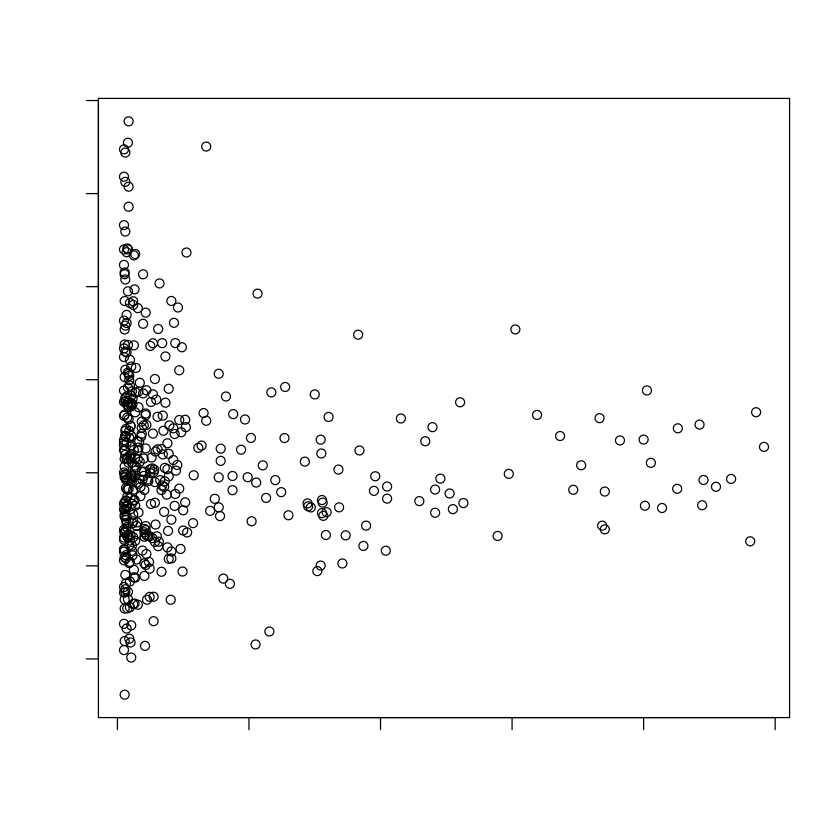

In [245]:
fasta_sumstats_filtered <- filter(fasta_sumstats, richness < 1000, avg_pi < 0.02)

plot(avg_pi ~ richness, data = fasta_sumstats_filtered)
summary(lm(avg_pi ~ richness, data = fasta_sumstats_filtered))

What about median pi?


Call:
lm(formula = median_pi ~ richness, data = fasta_sumstats)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0021088 -0.0006652 -0.0001983  0.0003514  0.0204076 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.110e-03  6.649e-05  31.735   <2e-16 ***
richness    -1.146e-07  9.556e-08  -1.199    0.231    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.00137 on 473 degrees of freedom
Multiple R-squared:  0.003031,	Adjusted R-squared:  0.0009229 
F-statistic: 1.438 on 1 and 473 DF,  p-value: 0.2311


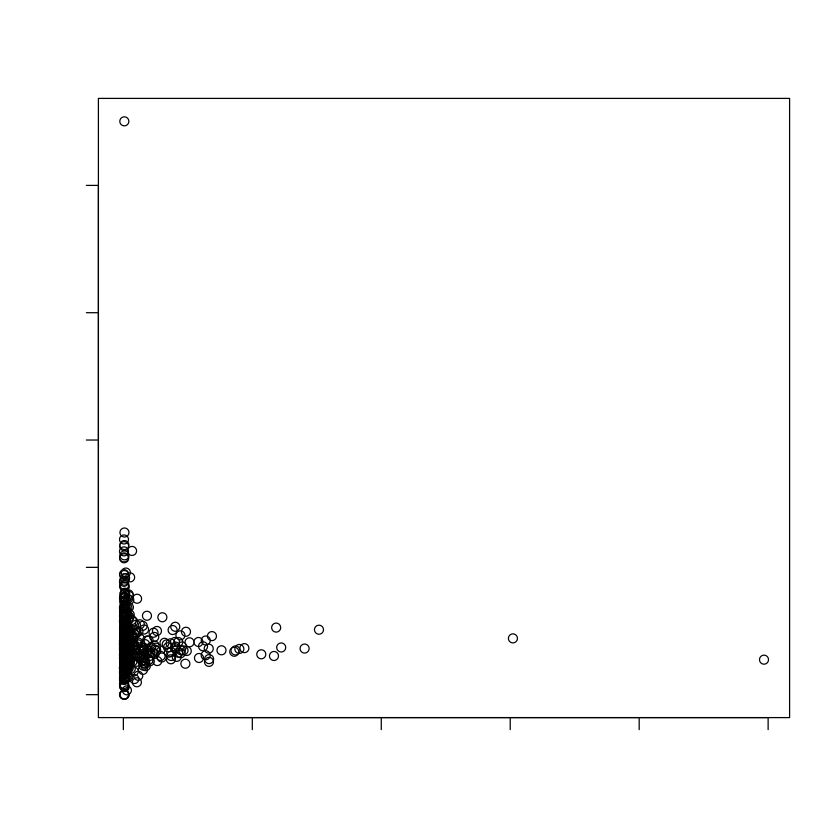

In [246]:
plot(median_pi ~ richness, data = fasta_sumstats)
summary(lm(median_pi ~ richness, data = fasta_sumstats))

Still nothing! Something to note: Judging by the p-value, the relationship becomes stronger at broader resolutions.


Call:
lm(formula = median_pi ~ richness, data = fasta_sumstats_filtered_m)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0021017 -0.0006446 -0.0001470  0.0003811  0.0042700 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.106e-03  5.600e-05  37.611   <2e-16 ***
richness    -4.490e-07  2.371e-07  -1.894   0.0589 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.001018 on 449 degrees of freedom
Multiple R-squared:  0.007925,	Adjusted R-squared:  0.005716 
F-statistic: 3.587 on 1 and 449 DF,  p-value: 0.05888


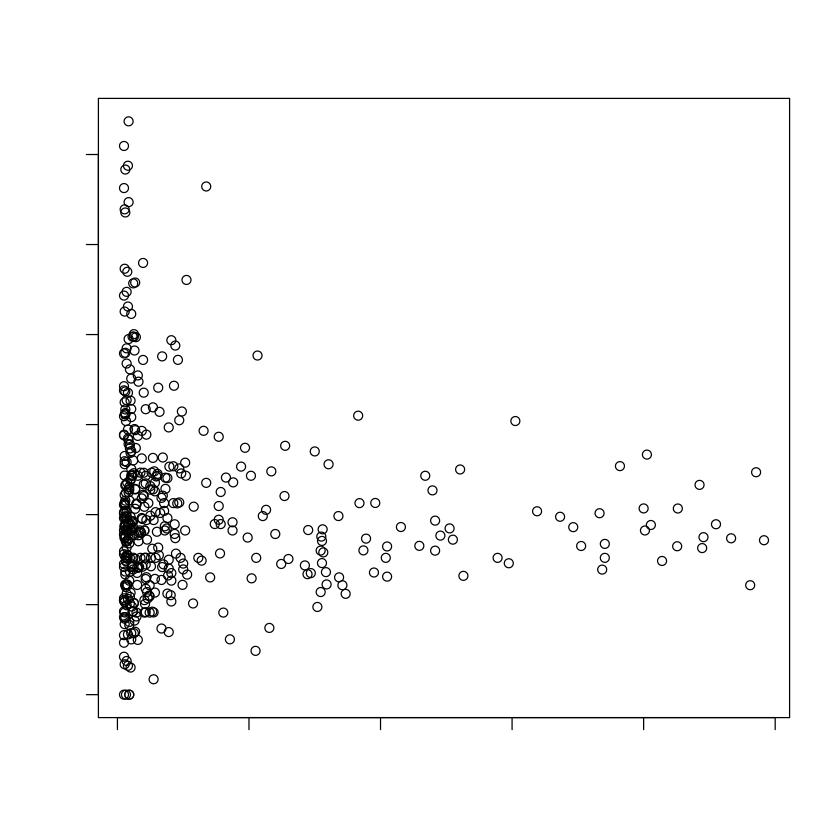

In [247]:
fasta_sumstats_filtered_m <- filter(fasta_sumstats, richness < 1000, median_pi < 0.02)

plot(median_pi ~ richness, data = fasta_sumstats_filtered_m)
summary(lm(median_pi ~ richness, data = fasta_sumstats_filtered_m))

In [248]:
fwrite(fasta_sumstats, file = here("output", "spreadsheets", paste0("sumstats_", res, ".csv")))

## Unused functions

Function to calculate per-site number of nucleotide differences between two sequences. If two sequences have less than 50% sequence overlap, I am not calculating pi.  
*Not used because I already determined that all sequences have < 50% overlap, and ape's dist.dna function is much faster than this function*

In [3]:
calc_div <- function(seqname1, seqname2, df) {
  
  # get the sequence vector
  seq1 <- filter(df, recordID == seqname1) %>% pull(seq) %>% unlist()
  seq2 <- filter(df, recordID == seqname2) %>% pull(seq) %>% unlist()

  # TRUE if site is not a gap or ambiguous site
  bp1 <- seq1 != "-" & seq1 != "n"
  bp2 <- seq2 != "-" & seq2 != "n"
  
  # number of shared sites that contain nucleotides / longest sequence sans gaps or ambiguous
  seq_overlap <- sum(bp1 == bp2 & bp1 & bp2) / max(sum(bp1), sum(bp2))
  if (seq_overlap >= 0.5) {
      
      # remove sites with gaps or ambiguous characters
      s1 <- seq1[bp1 & bp2]
      s2 <- seq2[bp1 & bp2]
    
      # calculate per-site pairwise divergence
      div <- (1 - sum(s1 == s2) / length(s1))
  } else div  <- NA
  
  return(div)
}

Function to correct for uneven OTU sampling through a resampling method. Preliminary exploration showed that this method was nearly perfectly correlated (R2 = 0.96) with Isaac's alternate correction by dividing by OTU richness, but this method is much slower. So I'm going with the other method. The other method scales from 0 to 1 as well, which is more intuitive to interpret.

In [ ]:
sample_hill <- function(x, q, n = 100) {
    s <- replicate(n, base::sample(x, size = 10, replace = TRUE), simplify = FALSE)
    hill <- map_dbl(s, ~hill_calc(.x, q, correct = FALSE))
    hill_avg <- mean(hill)
    return(hill_avg)
}